# Zeolite classifier + SHAP analysis for *ZeoSyn: A Comprehensive Zeolite Synthesis Dataset Enabling Machine-learning Rationalization of Hydrothermal Parameters*

Elton Pan,† Soonhyoung Kwon,‡ Zach Jensen,† Mingrou Xie,‡ Rafael Gomez-Bombarelli,† Manuel Moliner,¶ Yuriy Roman,‡ and Elsa Olivetti∗,†

† Department of Materials Science and Engineering, Massachusetts Institute of Technology, Cambridge, Massachusetts 02139, United States

‡ Department of Chemical Engineering, Massachusetts Institute of Technology, Cambridge, Massachusetts 02139, United States

¶ Instituto de Tecnolog ́ıa Qu ́ımica, Universitat Politecnica de Valencia-Consejo Superior de
Investigaciones Cient ́ıficas, 46022 Valencia, Spain

<p align="center">
  <img src="figures/TOC.png" width="1000"/> 
</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
import pickle

# 1) Dataset visualization

In [2]:
# Load ZeoSyn dataset
df = pd.read_excel('dataset/ZEOSYN.xlsx').drop(columns = 'Unnamed: 0')
df = df[~df['Si'].isna()].reset_index().drop(columns = 'index') # Remove empty rows
df

,Si,Al,P,Na,K,Li,Sr,Rb,Cs,Ba,...,osda1 smiles,osda2 smiles,osda3 smiles,osda1 formula,osda2 formula,osda3 formula,Code1,Code2,Code3,year
0,0.030769,0.000000,0.0,0.0,0.001538,0.000000,0.0,0.0,0.0,0.0,...,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...,NaN,NaN,C16H29N2,NaN,NaN,AFI,NaN,NaN,2002.0
1,0.105263,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...,NaN,NaN,C16H29N2,NaN,NaN,AFI,NaN,NaN,2002.0
2,0.021959,0.000000,0.0,0.0,0.002635,0.000000,0.0,0.0,0.0,0.0,...,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2,NaN,NaN,C13H24N,NaN,NaN,AFI,NaN,NaN,2002.0
3,0.046512,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2,NaN,NaN,C13H24N,NaN,NaN,AFI,NaN,NaN,2002.0
4,0.021368,0.008547,0.0,0.0,0.000000,0.004274,0.0,0.0,0.0,0.0,...,CC[N+](CC)(CC)CC,C[N+](C)(C)C,NaN,C8H20N,C4H12N,NaN,BPH,NaN,NaN,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,0.967742,0.032258,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,CC[N+]1(CC)CC2CC3CC(C2)CC1C3,NaN,NaN,C14H26N,NaN,NaN,CHA,NaN,NaN,2000.0
23957,0.975610,0.024390,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,CC[N+]1(CC)CC2CC3CC(C2)CC1C3,NaN,NaN,C14H26N,NaN,NaN,CHA,NaN,NaN,2000.0
23958,0.985915,0.014085,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,CC[N+]1(CC)CC2CC3CC(C2)CC1C3,NaN,NaN,C14H26N,NaN,NaN,AFI,NaN,NaN,2000.0
23959,0.990099,0.009901,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,CC[N+]1(CC)CC2CC3CC(C2)CC1C3,NaN,NaN,C14H26N,NaN,NaN,AFI,NaN,NaN,2000.0


## Get compositions
Here, we visualize the distributions of Si/Al and Al/P ratios

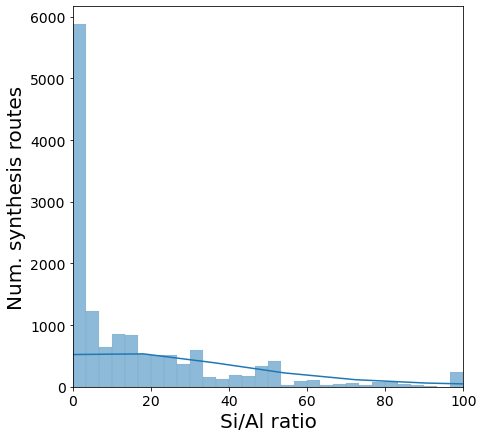

In [3]:
# Visualize distribution of Si/Al ratio
xlim = (0,100)
plt.figure(figsize=(7,7))
sns.histplot(df['Si']/df['Al'], bins=30, binrange=xlim, kde=True)
plt.xlabel('Si/Al ratio',fontsize=20)
plt.ylabel('Num. synthesis routes',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(*xlim)
plt.show()

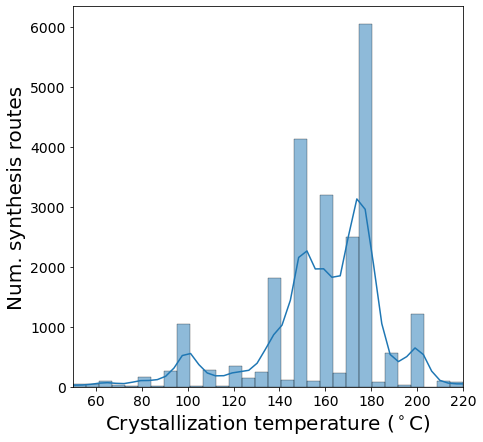

In [4]:
# Visualize distribution of crystallization temperature
xlim = (50,220)
plt.figure(figsize=(7,7))
sns.histplot(df['cryst_temp'], bins=30, binrange=xlim, kde=True)
plt.xlabel('Crystallization temperature ($^\circ$C)',fontsize=20)
plt.ylabel('Num. synthesis routes',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(*xlim)
plt.show()

## Organic structure-directing agents (OSDAs)

In [5]:
# OSDA smiles
df['osda1 smiles'].value_counts()

CC[N+](CC)(CC)CC                            1866
CCC[N+](CCC)(CCC)CCC                        1457
C[N+](C)(C)CCCCCC[N+](C)(C)C.[OH-].[OH-]     648
C[N+](C)(C)C                                 618
C1CCCNCC1                                    546
                                            ... 
Oc1cccc(O)c1                                   1
C1OCOCO1                                       1
OCCO                                           1
CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21                1
C1CCCC(C2CCCC2)(N2CCCCCCN2)CCC1                1
Name: osda1 smiles, Length: 879, dtype: int64

Here we look at some of the most frequent OSDAs in the dataset

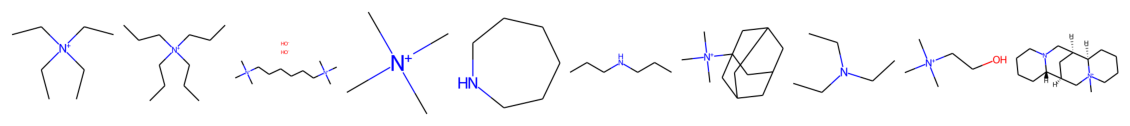

In [12]:
osdas = [Chem.MolFromSmiles(x) for x in df['osda1 smiles'].value_counts().keys()[:10]] # x is SMILES string of OSDA
plt.figure(figsize=(20,5))
plt.imshow(Chem.Draw.MolsToImage(osdas))
plt.axis('off')
plt.show()

We can take one step further and visualize the top 50 OSDAs in the following dendrogram, clustered using hierarchical clustering of their Morgan fingerprints. One can observe the different types of OSDAs, such as cyclic, spiro, linear etc. The code to generate this dendrogram can be found in `visualization.ipynb`.

Interestingly, we observe a significant correlation between OSDA size (orange) and zeolite pore size (purple).

<p align="center">
  <img src="figures/osdas_top50.png" width="1000"/> 
</p>

## Precursors
Precursors (eg. Si source, Al source, Na source) are also included in the dataset

In [7]:
# Precursors
df['precursors']

0                                  KOH, Aerosil 200
1                       tetraethylorthosilicate, HF
2                                  KOH, Aerosil 200
3                                                HF
4        aluminum hydroxide, colloidal silica, LiCl
                            ...                    
23956                NaOH, Banco N silicate, LZY-62
23957                      NaOH, Cabosil M5, LZY-52
23958                      NaOH, Cabosil M5, LZY-52
23959               NaOH, Reheis F-2000, Cabosil M5
23960                           NaOH, Tosoh 390 HUA
Name: precursors, Length: 23961, dtype: object

## Zeolite products

Zeolite products are provided in terms of their 3-letter IZA code (eg. 'AFI', 'CHA')

In [8]:
# Framework products 
df[['Code1', 'Code2', 'Code3']]

,Code1,Code2,Code3
0,AFI,NaN,NaN
1,AFI,NaN,NaN
2,AFI,NaN,NaN
3,AFI,NaN,NaN
4,BPH,NaN,NaN
...,...,...,...
23956,CHA,NaN,NaN
23957,CHA,NaN,NaN
23958,AFI,NaN,NaN
23959,AFI,NaN,NaN


# 2) Zeolite framework-level SHAP
Framework-level SHAP analysis revealing the top 10 (out of 43) most important synthesis parameters favoring the formation of specific frameworks.

In [9]:
# Load pre-computed SHAP values
with open('shap/shap_values.pkl', 'rb') as handle:
    shap_values = pickle.load(handle)

In [10]:
# Mask out non-relevant features
shap_cols     = [] # columns to remain
shap_col_idxs = [] # their indices
for col_idx, col in enumerate(X_test.columns):
        shap_cols.append(col)
        shap_col_idxs.append(col_idx)

shap_values_masked = [x[:,shap_col_idxs] for x in shap_values]
X_test_masked      = X_test[shap_cols]
X_test_masked.columns = X_cols.values()
shap_values_masked[0].shape, X_test_masked.shape

NameError: name 'X_test' is not defined

Each framework belongs to 1 out of 3 types of synthesis based on its top synthesis parameters: 1) Gel-dominated synthesis (CAN, KFI) where most top parameters are inorganic-related, 2) OSDA-dominated synthesis (ISV, ITE) where most top parameters are OSDA-related, and 3) balanced syn- thesis (IWW, RUT) where even attribution is given to inorganic and OSDA parameters. Every point is an individual synthesis colored by the value of synthesis parameter (orange and blue colors indicate high and low values, respectively).

<p align="center">
  <img src="figures/framework_shap.png" width="1200"/> 
</p>

# 3) Zeolite CBU-level SHAP
CBU-level SHAP analysis of large CBUs showing OSDA parameters favoring their formation.

## Small CBUs
We uncover the most important inorganic parameters driving the formation of a selection of 4 small CBUs in the figure below. As shown, the synthesis of small CBUs shown are all inorganic/gel-dominated instead of OSDA-dominated with the top 5 parameters relating to the inorganic components.

<p align="center">
  <img src="figures/small_cbu_shap.png" width="1000"/> 
</p>

## Large CBUs
In contrast to small CBUs, the formation of large CBUs are influenced by OSDA parameters due to the need for a structure-directing effect by OSDAs. The figure below shows a series of large CBUs (≥ 30 T sites) with an increasing aspect ratio (*pau* < *los* < *ave* < *aft*). 

Interestingly, in the first row, CBU-level SHAP discovers a clear relationship between aspect ratio of the CBU and OSDA asphericity (a measure of the deviation from sphere). For *pau*, low OSDA asphericity (dark blue on positive side) gives rise to positive SHAP values, indicating the need for a spherical OSDA. Indeed, this is due to the symmetrical shape of the pau cage. The inverse is true for *aft*.

<p align="center">
  <img src="figures/large_cbu_shap.png" width="1600"/> 
</p>